In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names = open("/home/tamir/workspace/makemore/name_scrapper/extracted_values.txt", "r").read().splitlines()
names = [name.lower() for name in names]
names[:8]

['аасүрэн', 'аахүү', 'аажим', 'аадар', 'аажий', 'аандаа', 'аажимбаяр', 'аарон']

In [3]:
#build the vobaculary of characters and mappings to integer
chars = sorted(list(set("".join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'а', 2: 'б', 3: 'в', 4: 'г', 5: 'д', 6: 'е', 7: 'ж', 8: 'з', 9: 'и', 10: 'й', 11: 'к', 12: 'л', 13: 'м', 14: 'н', 15: 'о', 16: 'п', 17: 'р', 18: 'с', 19: 'т', 20: 'у', 21: 'ф', 22: 'х', 23: 'ц', 24: 'ч', 25: 'ш', 26: 'щ', 27: 'ъ', 28: 'ы', 29: 'ь', 30: 'э', 31: 'ю', 32: 'я', 33: 'ё', 34: 'ү', 35: 'ө', 0: '.'}
36


In [4]:
#building the dataset
block_size = 3

def build_dataset(names):
    
    X, Y = [], []    
    for w in names:
        
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X, Y = build_dataset(names)

Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xval, Yval = X[n2:], Y[n2:]

In [5]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([18909, 3]), torch.int64, torch.Size([18909]), torch.int64)

In [30]:
sum(p.nelement() for p in parameters) # number of parameters

20556

In [92]:
# make our neural network more ptytorchy 

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.std(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 20 # the dimentionality of character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(95102218)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].gamma *= 0.1
    #make all layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

183028


In [93]:
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
        
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    if i % 1000 == 0:
        print(f"{i:7d} / {max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0 /   10000: 3.5681
   1000 /   10000: 2.0528


layer 2 (      Tanh): mean +0.00, std 0.69, saturated: 9.17%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 5.38%
layer 8 (      Tanh): mean -0.00, std 0.67, saturated: 4.72%
layer 11 (      Tanh): mean -0.00, std 0.67, saturated: 4.94%
layer 14 (      Tanh): mean +0.00, std 0.68, saturated: 5.22%


Text(0.5, 1.0, 'activation distribution')

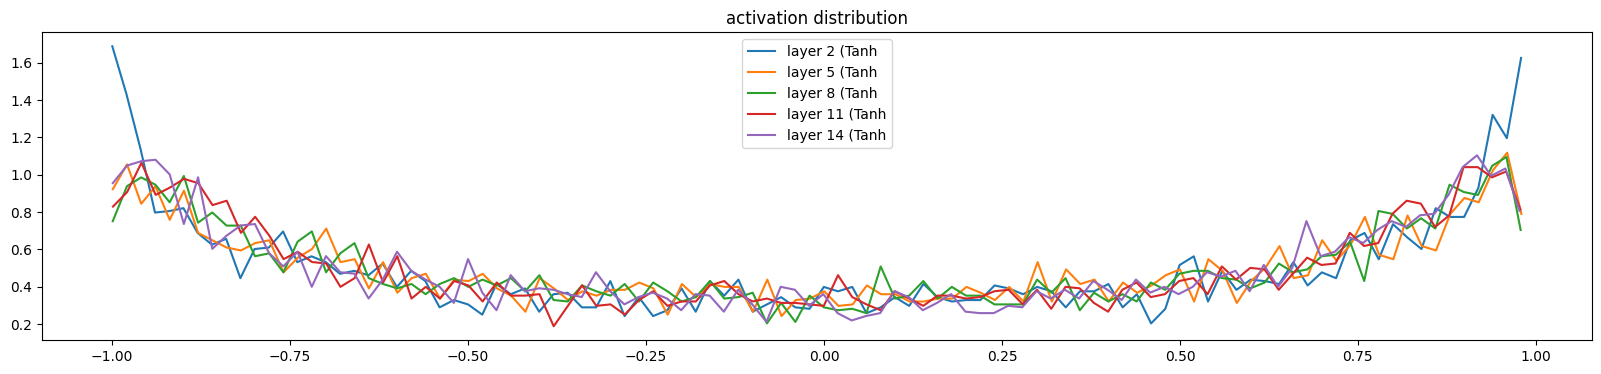

In [94]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.806538e-03
layer 5 (      Tanh): mean -0.000000, std 2.595636e-03
layer 8 (      Tanh): mean -0.000000, std 2.358242e-03
layer 11 (      Tanh): mean -0.000000, std 2.214817e-03
layer 14 (      Tanh): mean -0.000000, std 2.038414e-03


Text(0.5, 1.0, 'gradient distribution')

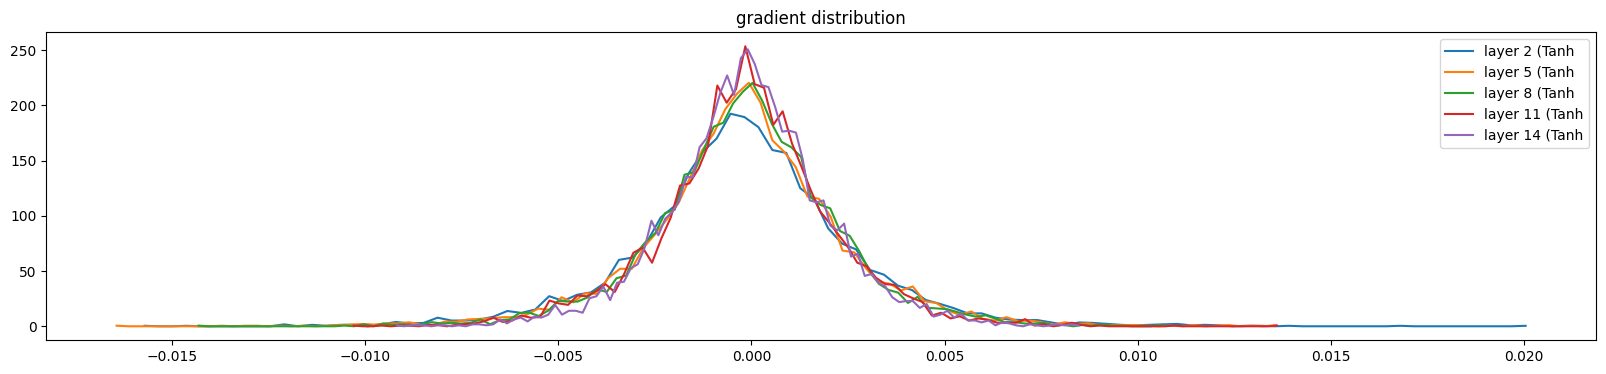

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (36, 20) | mean -0.000000 | std 8.003891e-03 | grad:data ratio 8.009761e-03
weight  (60, 200) | mean +0.000057 | std 8.044072e-03 | grad:data ratio 3.754721e-02
weight (200, 200) | mean +0.000043 | std 6.313241e-03 | grad:data ratio 5.344059e-02
weight (200, 200) | mean -0.000017 | std 5.466420e-03 | grad:data ratio 4.578658e-02
weight (200, 200) | mean -0.000003 | std 5.110807e-03 | grad:data ratio 4.318586e-02
weight (200, 200) | mean -0.000025 | std 4.610053e-03 | grad:data ratio 3.882835e-02
weight  (200, 36) | mean -0.000009 | std 1.008826e-02 | grad:data ratio 8.073462e-02


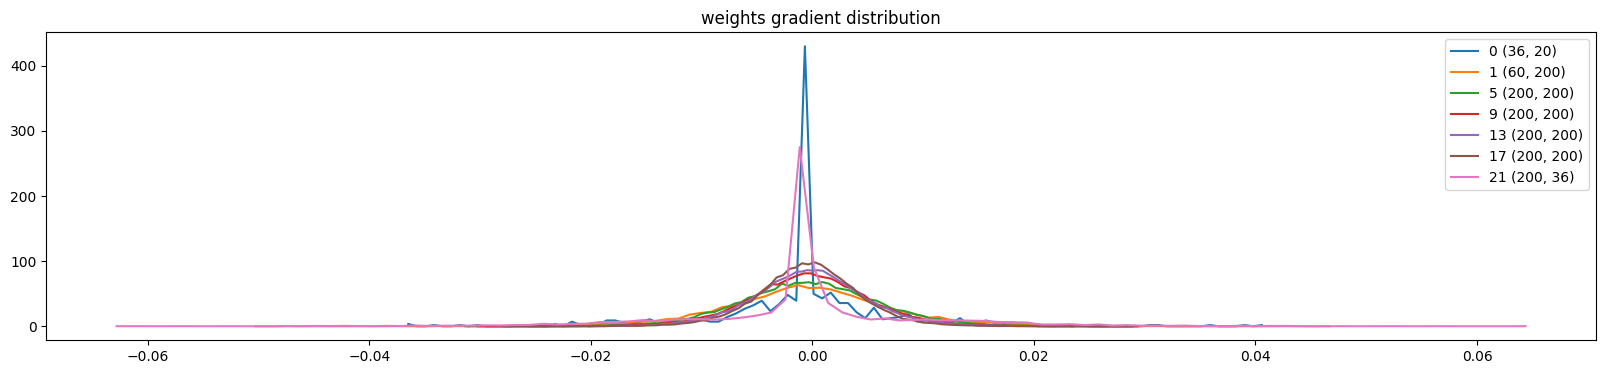

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

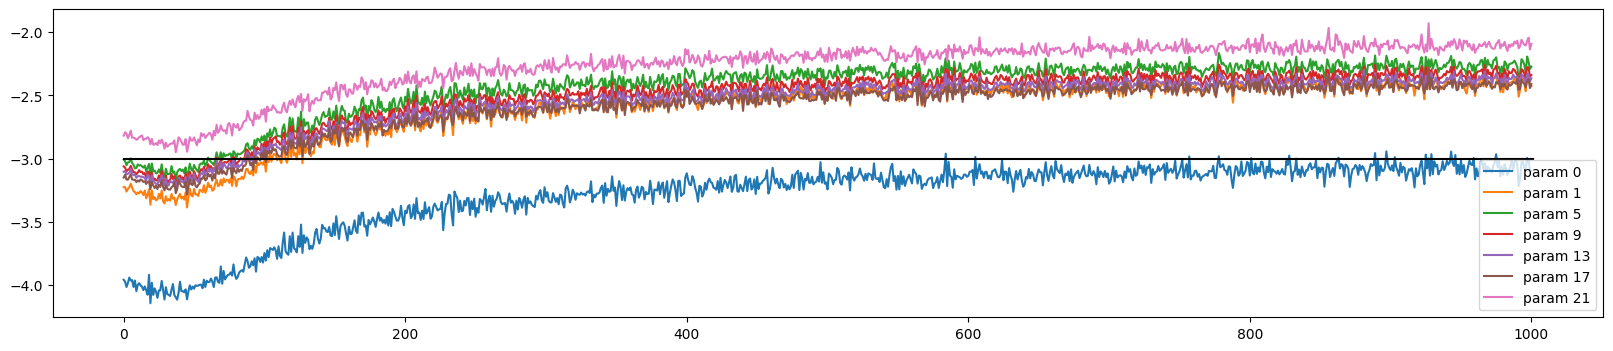

In [97]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [64]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xdev, Ydev),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.5833704471588135
val 3.5829503536224365


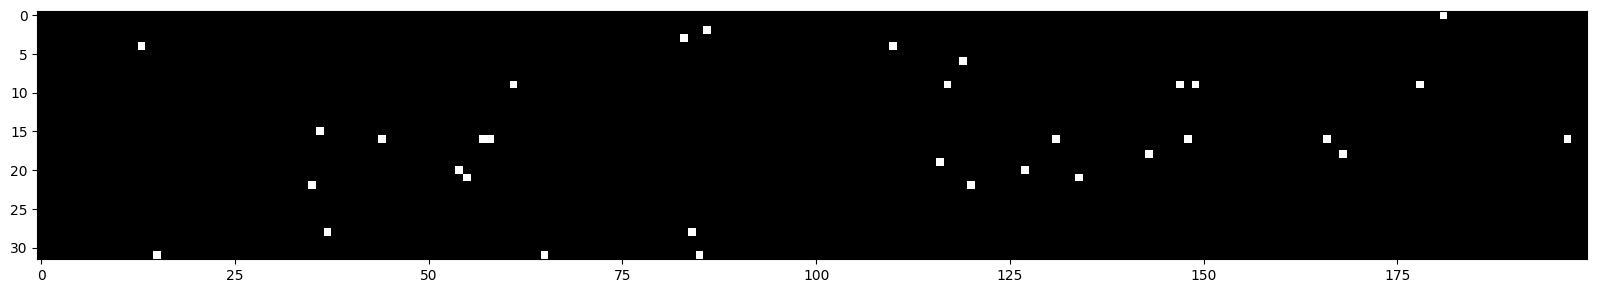

In [40]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([168., 192., 175., 169., 137., 150., 150., 149., 106., 122., 119.,
        150., 118., 110., 120., 113., 128., 102., 110., 102., 110., 114.,
        101.,  96., 102.,  93.,  93.,  75., 102., 111.,  96., 138.,  98.,
         97.,  98., 141., 114., 125., 115., 143., 115., 138., 158., 144.,
        132., 173., 170., 168., 195., 155.]),
 array([-9.99141455e-01, -9.59196495e-01, -9.19251535e-01, -8.79306575e-01,
        -8.39361615e-01, -7.99416655e-01, -7.59471695e-01, -7.19526736e-01,
        -6.79581776e-01, -6.39636816e-01, -5.99691856e-01, -5.59746896e-01,
        -5.19801936e-01, -4.79856976e-01, -4.39912016e-01, -3.99967057e-01,
        -3.60022097e-01, -3.20077137e-01, -2.80132177e-01, -2.40187217e-01,
        -2.00242257e-01, -1.60297297e-01, -1.20352337e-01, -8.04073775e-02,
        -4.04624176e-02, -5.17457724e-04,  3.94275022e-02,  7.93724620e-02,
         1.19317422e-01,  1.59262382e-01,  1.99207342e-01,  2.39152302e-01,
         2.79097261e-01,  3.19042221e-01,  3.58987

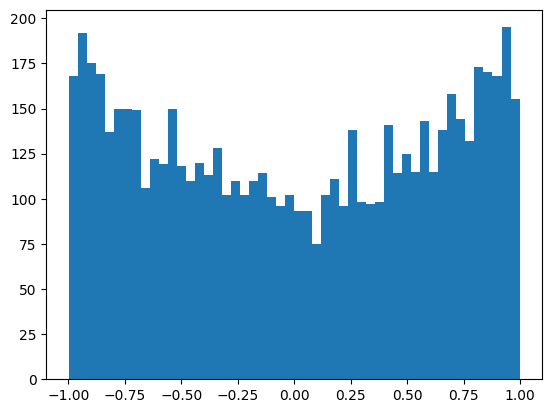

In [41]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   1.,   2.,   1.,   2.,   6.,  13.,  22.,  27.,
         31.,  52.,  58.,  79., 107., 132., 160., 173., 226., 253., 279.,
        349., 365., 370., 371., 356., 347., 367., 367., 326., 269., 276.,
        210., 182., 146., 120., 103.,  71.,  58.,  39.,  27.,  17.,  18.,
          8.,   5.,   2.,   3.,   1.,   2.]),
 array([-3.87651181, -3.7293662 , -3.58222059, -3.43507498, -3.28792937,
        -3.14078376, -2.99363815, -2.84649254, -2.69934693, -2.55220132,
        -2.40505571, -2.2579101 , -2.11076449, -1.96361888, -1.81647327,
        -1.66932766, -1.52218205, -1.37503644, -1.22789083, -1.08074522,
        -0.93359962, -0.78645401, -0.6393084 , -0.49216279, -0.34501718,
        -0.19787157, -0.05072596,  0.09641965,  0.24356526,  0.39071087,
         0.53785648,  0.68500209,  0.8321477 ,  0.97929331,  1.12643892,
         1.27358453,  1.42073014,  1.56787575,  1.71502136,  1.86216697,
         2.00931258,  2.15645819,  2.3036038 ,  2.45074941,  2.59789502,
 

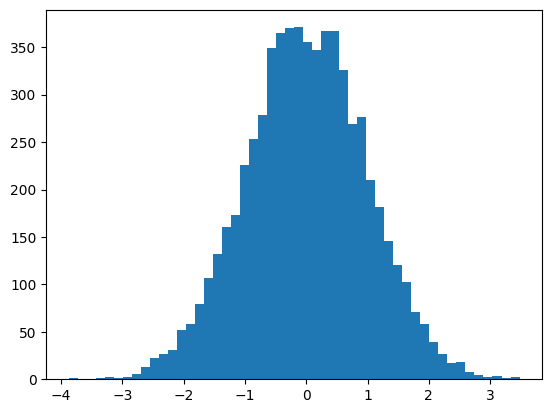

In [42]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [143]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.670264482498169

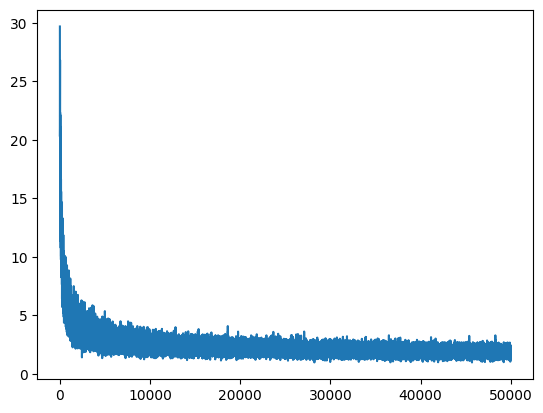

In [141]:
plt.plot(stepi, lossi)

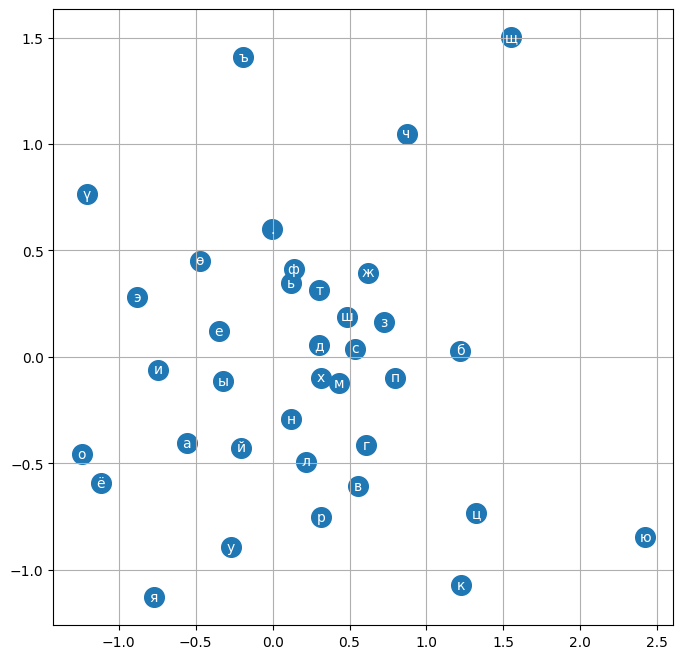

In [129]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')

In [148]:
#sampling the model

g = torch.Generator().manual_seed(95102218 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break

    print(''.join(itos[i] for i in out))

лүмдэмбэрдигчаа.
херцэцэг.
занд.
ашидэрмарысбердиенжгээ.
бет.
кетебек.
рай.
ажефаримил.
ойшийн.
бондахишигбат.
